In [1]:
!pip install rembg==2.0.56 -q

# Imports

In [2]:
import os
import cv2
import numpy as np
from PIL import Image

# Remove Later
import csv
import pandas as pd
import matplotlib.pyplot as plt
from rembg import new_session, remove

# Constant

In [3]:
BASE_PATH = '/kaggle/input/key-images/'

# Models

In [17]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, cropped_feature=None, key_contour=None):
        self.rgb_img = rgb_img                 # Original Img (RGB)
        self.mask_img = mask_img               # Orignal Img Mask (Binary)
        self.cropped_mask = cropped_mask       # Cropped Mask (Rotated + Binary)
        self.cropped_feature = cropped_feature # Cropped Feature (Rotated + Grayscale)
        self.key_contour = key_contour         # Key Contour

# Utils

In [56]:
def fix_image_size(image, ellipse_center=None):
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    dimension = max(original_height, original_width)
#     dimension += 1000

    # Create a blank canvas of the desired size
    canvas = np.zeros((dimension, dimension), dtype=np.uint8)

    # Calculate the offset to center the image on the canvas
    offset_x = (canvas.shape[1] - image.shape[1]) // 2
    offset_y = (canvas.shape[0] - image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+image.shape[0], offset_x:offset_x+image.shape[1]] = image
    
    # Modify ellipse center
#     center_x = ellipse_center[0] + offset_x
#     center_y = ellipse_center[1] + offset_y

    return canvas, (int(center_x), int(center_y))


def resize_grayscale_image_to_256x256(image):
    WIDTH = 232
    HEIGHT = 232
    PADDING = 12
    
    DIMENSION = (WIDTH,HEIGHT,PADDING)

    return resize_grayscale_image(image, DIMENSION)


def resize_grayscale_image(image, dimension):
    WIDTH, HEIGHT, PADDING = dimension
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image
    
    return canvas


def is_ellipse_center_below_lower_half(center, image_shape):
    center_x, center_y = center
    image_width, image_height = image_shape
    return True if (center_y > image_height / 2) else False


def get_rotation_angle(is_below, current_angle):
    new_angle = 0
    if current_angle < 90:
        new_angle = 90 + current_angle
    elif current_angle > 90 and current_angle < 180:
        new_angle = current_angle - 90
    
    return (new_angle + 180) if is_below else (new_angle + 180)


# def get_rotation_angle(is_below, current_angle):
#     if current_angle > 90 and current_angle < 180:
#         diff_angle = 180 - current_angle
#         return current_angle - diff_angle
#     elif current_angle < 90:
#         diff_angle = 180 - current_angle
#         return current_angle + diff_angle
#     else:
#         return current_angle

def contrast_using_dynamic_gamma(image):
    '''
    Dynamically adjust the gamma value of an image based on its mean pixel intensity.
    '''
    mean_intensity = np.mean(image)

    # Determine the gamma value based on mean intensity
    # You can adjust these thresholds and gamma values based on your requirements
    if mean_intensity < 50:
        gamma = 2.5  # Very dark image
    elif mean_intensity < 100:
        gamma = 2.0  # Dark image
    elif mean_intensity < 150:
        gamma = 2.0  # 1.5 - Slightly dark image
    elif mean_intensity < 200:
        gamma = 1.7  # 1.0 - Normal image
    else:
        gamma = 0.5  # Bright image

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table), gamma

In [98]:
def image_processing_pipeline(image_path):
    # 1. Read img as RGB
    rgb_img = np.array(Image.open(image_path))

    # 2. Convert RGB to Grayscale, contrast it & create an empty img of same dimension
    grayscale_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    grayscale_img, _ = contrast_using_dynamic_gamma(grayscale_img)
    empty_img = np.zeros_like(grayscale_img, dtype=np.uint8)

    # 3. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)

    # 4. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)

    # 5. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]

    # 6. Extract and paste only region of interest to grayscale image
    cv2.drawContours(empty_img, contours, -1, (255), thickness=cv2.FILLED)
    cropped_feature = cv2.bitwise_and(grayscale_img, grayscale_img, mask=empty_img)

    # 7. Make model object
    img_model = ImageModel(rgb_img=np.array(rgb_img),
                           mask_img=mask_img,
                           cropped_mask=cropped_mask, # Useless
                           cropped_feature=cropped_feature, # Useless right now
                           key_contour=contours[0])
    
    # 8. Rotate key inside the image by fitting ellipse
    ellipse = cv2.fitEllipse(img_model.key_contour)
    center, axis_lengths, current_angle = ellipse
    is_below = is_ellipse_center_below_lower_half(center, img_model.mask_img.shape)
    rotation_angle = (90 + current_angle) + 180 #get_rotation_angle(is_below, current_angle)
    print(current_angle, rotation_angle)
    
    plt_ellipse(rgb_img, ellipse)

    # 9. Resize mask and grayscale image before applying rotation
    resized_binary_image, new_center = fix_image_size(img_model.mask_img, center)
    resized_grayscale_image, new_center = fix_image_size(img_model.cropped_feature, center)
    
#     print(img_model.mask_img.shape, resized_binary_image.shape)


    # 10. Apply rotation
#     center = (resized_binary_image.shape[1] // 2, resized_binary_image.shape[0] // 2)
    rot_mat = cv2.getRotationMatrix2D(new_center, rotation_angle, 1.0)
    
#     print(new_center)
#     temp_img = resized_grayscale_image
#     cv2.circle(temp_img, new_center, 20, (255, 255, 255), 20)
#     plt_img(temp_img)
    

    rotated_binary_image = cv2.warpAffine(resized_binary_image, rot_mat, resized_binary_image.shape[1::-1])
    rotated_grayscale_image = cv2.warpAffine(resized_grayscale_image, rot_mat, resized_grayscale_image.shape[1::-1])

    # 11. Cropped the rotated masked img
    contours, _ = cv2.findContours(rotated_binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    x,y,w,h = cv2.boundingRect(contours[0])
    rotated_binary_image = rotated_binary_image[y:y+h, x:x+w]
    rotated_grayscale_image = rotated_grayscale_image[y:y+h, x:x+w]

    # 12. Updated cropped masked
    img_model.cropped_mask = rotated_binary_image
    img_model.cropped_feature = rotated_grayscale_image
    
    # 13. Resized cropped feature t0 256x256
    rezised_feature = resize_grayscale_image_to_256x256(img_model.cropped_feature)
    
    return img_model, rezised_feature

In [95]:
def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def plt_contour(contour):
    # Find the bounding box of the contour
    x, y, w, h = cv2.boundingRect(contour)

    # Create an empty black image with dimensions based on the bounding box
    blank_image = np.zeros((h, w, 3), dtype=np.uint8)

    # Draw the contour on the black image with the contour shifted to the top-left corner of the bounding box
    shifted_contour = contour - np.array([x, y])
    contour_image = cv2.drawContours(blank_image, [shifted_contour], -1, (0, 0, 255), thickness=cv2.FILLED)
    
    plt_img(contour_image)
    
    
def draw_ellipse(rgb_img, ellipse):
    center, axis_lengths, current_angle = ellipse
    
    # Draw the ellipse on the image
    cv2.ellipse(rgb_img, ellipse, (0, 255, 0), 5)

    # Draw the center of the ellipse
    center_point = (int(center[0]), int(center[1]))
    cv2.circle(rgb_img, center_point, 20, (255, 0, 0), 20)

    # Draw the axis lengths (major and minor axes)
    major_axis_length = axis_lengths[1] / 2
    minor_axis_length = axis_lengths[0] / 2
    
    # Convert angles to radians for calculation
    angle_rad = np.deg2rad(current_angle)
    perpendicular_angle_rad = angle_rad + np.pi / 2

    # Calculate the endpoints of the major axis
    major_axis_x = int(center[0] + major_axis_length * np.cos(angle_rad))
    major_axis_y = int(center[1] + major_axis_length * np.sin(angle_rad))
    cv2.line(rgb_img, center_point, (major_axis_x, major_axis_y), (0, 0, 255), 10)

    # Calculate the endpoints of the minor axis
    minor_axis_x = int(center[0] - minor_axis_length * np.sin(angle_rad))
    minor_axis_y = int(center[1] + minor_axis_length * np.cos(angle_rad))
    cv2.line(rgb_img, center_point, (minor_axis_x, minor_axis_y), (0, 0, 255), 10)
    
    # Calculate the rotation matrix
    rotation_angle = -current_angle
    rotation_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)

    # Get the dimensions of the image
    (h, w) = img_model.rgb_img.shape[:2]

    # Apply the rotation to the image
    rotated_img = cv2.warpAffine(img_model.rgb_img, rotation_matrix, (w, h))

    return rgb_img, rotated_img


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()


def plt_ellipse(image, ellipse):
    center, axis_lengths, current_angle = ellipse

    # Calculate the end points of the line
    major_axis_length = axis_lengths[1]
    angle_rad = np.deg2rad(current_angle)

    end_point1 = (
        int(center[0] + major_axis_length / 2 * np.cos(angle_rad)),
        int(center[1] + major_axis_length / 2 * np.sin(angle_rad))
    )
    end_point2 = (
        int(center[0] - major_axis_length / 2 * np.cos(angle_rad)),
        int(center[1] - major_axis_length / 2 * np.sin(angle_rad))
    )

    # Draw the ellipse on the image
    cv2.ellipse(image, ellipse, (0, 255, 0), 20)
    
    # Draw the line passing through the ellipse center
    cv2.line(image, end_point1, end_point2, (255, 0, 0), 4)
    cv2.circle(image,(int(center[0]), int(center[1])), 20, (0, 0, 255), 20)

    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt_img(image_rgb, cmap='viridis')

# Code

In [96]:
# img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}/1b.jpeg')
# # plt_img(resized_feature, cmap='gray')
# img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}/2a.jpeg')
# # plt_img(resized_feature, cmap='gray')
# img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}/2b.jpeg')
# # plt_img(resized_feature, cmap='gray')
# # img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}/3.jpeg')
# # plt_img(resized_feature, cmap='gray')
# img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}/4.jpeg')
# # plt_img(resized_feature, cmap='gray')

6.634866714477539 276.63486671447754


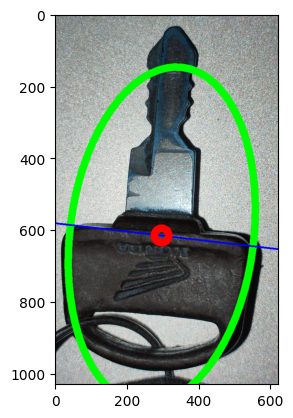

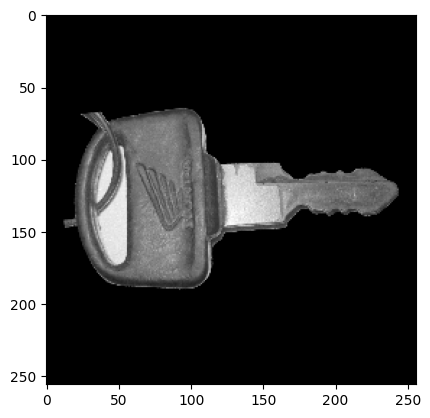

In [99]:
img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}dark-contrast/1717666137.png')
plt_img(resized_feature, cmap='gray')

8.043599128723145 278.04359912872314


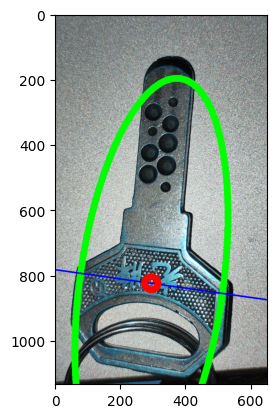

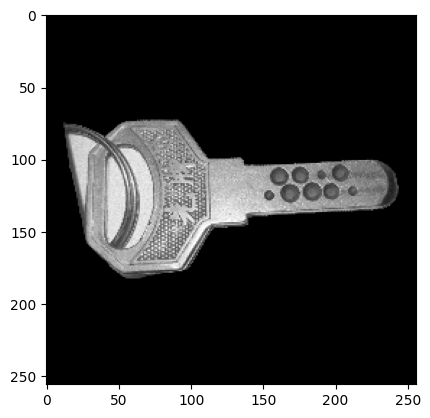

In [100]:
img_model, resized_feature = image_processing_pipeline(f'{BASE_PATH}dark-contrast/1717681430.png')
plt_img(resized_feature, cmap='gray')